In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [2]:
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [43]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation

In [44]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("dataset/ometiff_img_split/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

In [45]:
print(len(train_images))

72


In [46]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("dataset/ometiff_mask_split/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [47]:
print(len(train_masks))

72


In [48]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

array([0, 1], dtype=int64)

In [49]:
#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [50]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

Class values in the dataset are ...  [0 1]


In [51]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [52]:
###############################################################
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16,
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('project_model.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')

Class weights are...: [ 0.5118787  21.54608219]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 128, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 16) 2320        dropout_19[0][0]                 
____________________________________________

51/51 [==============================] - 11s 207ms/sample - loss: 1.4288 - accuracy: 0.1758 - val_loss: 0.8229 - val_accuracy: 0.7757
Epoch 2/50
51/51 [==============================] - 8s 151ms/sample - loss: 0.7960 - accuracy: 0.8164 - val_loss: 0.5102 - val_accuracy: 0.9667
Epoch 3/50
51/51 [==============================] - 8s 151ms/sample - loss: 0.3831 - accuracy: 0.9631 - val_loss: 0.4742 - val_accuracy: 0.9684
Epoch 4/50
51/51 [==============================] - 8s 154ms/sample - loss: 0.3847 - accuracy: 0.9755 - val_loss: 0.5089 - val_accuracy: 0.9684
Epoch 5/50
51/51 [==============================] - 8s 152ms/sample - loss: 0.3839 - accuracy: 0.9760 - val_loss: 0.5086 - val_accuracy: 0.9684
Epoch 6/50
51/51 [==============================] - 8s 150ms/sample - loss: 0.3839 - accuracy: 0.9761 - val_loss: 0.5090 - val_accuracy: 0.9684
Epoch 7/50
51/51 [==============================] - 8s 150ms/sample - loss: 0.3839 - accuracy: 0.9761 - val_loss: 0.5093 - val_accuracy: 0.9684
Ep

In [53]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

8/1 [================================================================================================================================================================================================================================================] - 0s 52ms/sample - loss: 0.5092 - accuracy: 0.9684
Accuracy is =  96.84066772460938 %


In [54]:
print(history.history)

{'loss': [1.428794690206939, 0.7959619567674749, 0.38312987135905846, 0.3846992251335406, 0.38389669563256057, 0.38389838472300886, 0.38393395934619157, 0.38397784560334447, 0.3838929758936751, 0.38392412399544434, 0.3838649412580565, 0.3838304585101558, 0.3838711138449463, 0.38380348419441895, 0.3837929037856121, 0.383788034027698, 0.3838094461197947, 0.3838073073648939, 0.38375843477015403, 0.383780608866729, 0.3837890645452574, 0.3837958226601283, 0.3837889803975236, 0.38378365162540884, 0.38376909377528173, 0.38380177465139653, 0.3837670213451572, 0.38379718071105434, 0.38377057220421584, 0.3837837679129021, 0.3837709321695216, 0.3837709196057974, 0.38379546444790036, 0.38378626195823445, 0.38376710899904665, 0.3837907477921131, 0.38381045735349845, 0.38377974781335567, 0.38379184638752656, 0.3837844825842801, 0.3837749627875347, 0.3837681625987969, 0.38376598001695145, 0.3837920365964665, 0.38378456497893615, 0.3837648595080656, 0.38377182507047464, 0.38379089738808425, 0.38376866

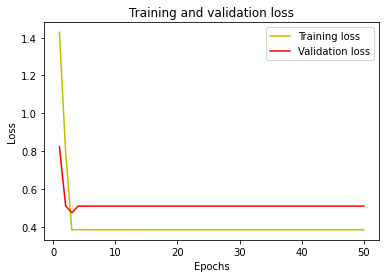

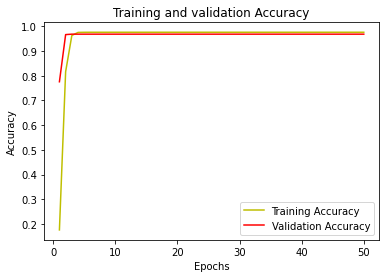

In [55]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##################################

Mean IoU = 0.48809516
[[815689.      0.      0.      0.]
 [ 19895.      0.      0.      0.]
 [     0.      0.      0.      0.]
 [     0.      0.      0.      0.]]
IoU for class1 is:  0.9761903052236519
IoU for class2 is:  0.0
IoU for class3 is:  nan
IoU for class4 is:  nan


D:\Anaconda3\envs\cits5508-fix\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
D:\Anaconda3\envs\cits5508-fix\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


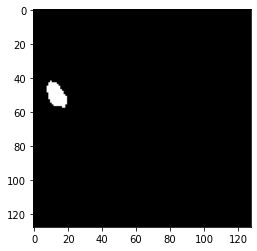

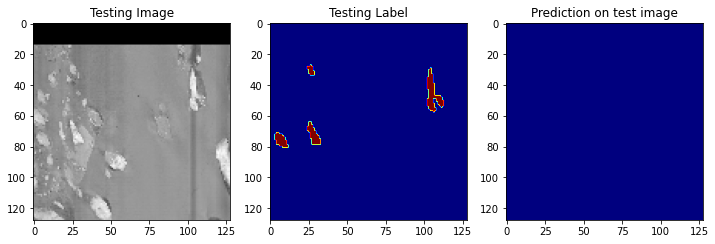

In [56]:
#IOU
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from tensorflow.keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_train[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_train))
test_img = X_train[test_img_number]
ground_truth=y_train[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7


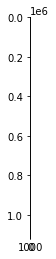

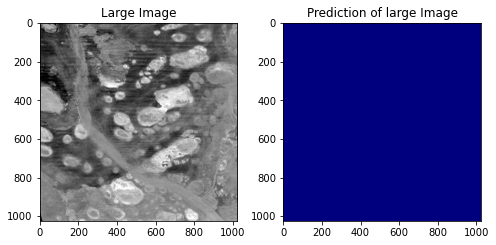

In [57]:
#####################################################################

#Predict on large image

#Apply a trained model on large image

from patchify import patchify, unpatchify

large_image = cv2.imread('cropped_ShallowInterval_MeanAmp5_GreyScale_AutoContrast_40_split1.ome.tiff', 0)
large_image = cv2.resize(large_image, (1024, 1024))
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()

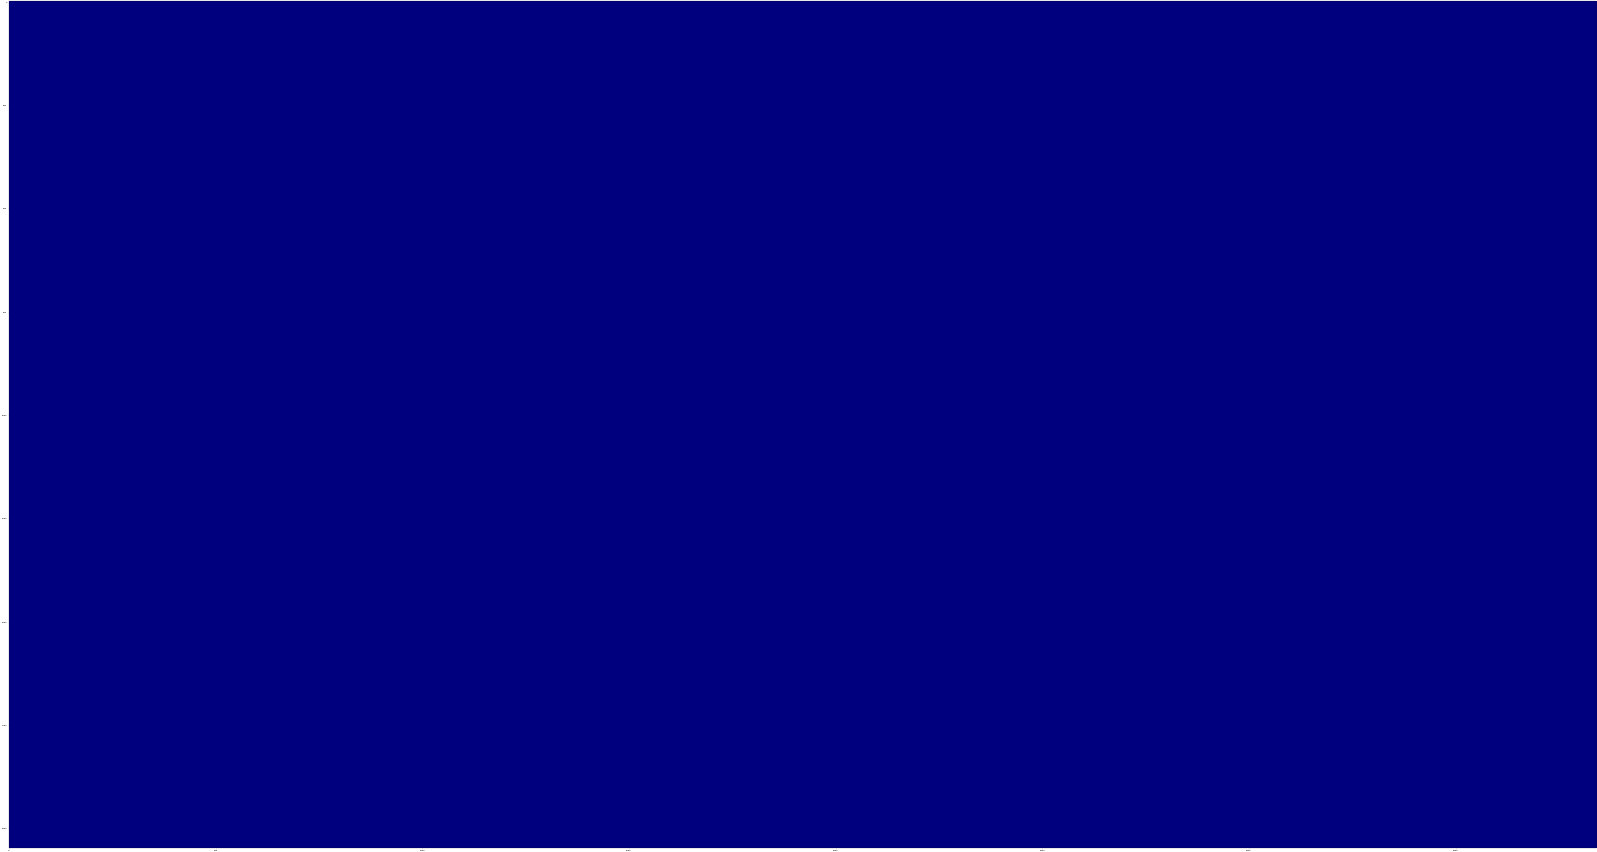

In [34]:
plt.figure(figsize=(128, 128),dpi=16)
plt.imshow(reconstructed_image, cmap='jet')
plt.savefig("filename.png")
plt.show()

In [34]:
plt.savefig("filename.png")

<Figure size 432x288 with 0 Axes>